# Solving Decentralizded Optimal Exchange Problem with BlueFog 

#### In this example, you will learn:

- How to solve optimal exchange problem with centralized ADMM;


- How to solve optimal exchange problem with decentralized algorithms such as EXTRA, Exact Diffusion, and Gradient Tracking;


- How to setup topology, determine weights, and run neighbor_allreduce with BlueFog;


- How to use BlueFog functions such as **bf.allreduce(), bf.neighbor_allreduce(), bf.load_topology(), bf.set_topology(), topology_util.GetRecvWeights()**, and **topology_util.ExponentialTwoGraph()**


- How to implement EXTRA, Exact Diffusion, and Gradient Tracking with BlueFog

**Note**: If you are not familiar with how to use BlueFog with Jupyter Notebook, please check out the example [interactive_bluefog_helloworld.ipynb](https://github.com/Bluefog-Lib/bluefog/blob/master/examples/interactive_bluefog_helloworld.ipynb) first.

## 1. Optimal exchange problem

A network of $n$ nodes collaborate to solve an optimal exchange problem as follows:

$$\min_{\{x_i\}} \ \sum_{i=1}^n f_i(x_i) \quad \mathrm{s.t.}\ \sum_{i=1}^n x_i = 0.$$

This and related problems have a long history in economics, particularly in the theories
of market exchange, resource allocation, and general equilibrium. In this example, we will simulate how EXTRA, Exact Diffusion, and Gradient Tracking solve the above problem over a cluster of $n$ CPUs. 

## 2. KKT Condition

The Lagrangian function of the optimal exchange problem is:

$$L(x, y) = \sum_{i=1}^n f_i(x_i) + y^T(\sum_{i=1}^n x_i)$$

where $y$ is the dual variable. The KKT condition is:

\begin{equation*}
\begin{split}
\nabla f_i(x_i) + y & = 0, \quad \forall\ i\in [n] \\
\sum_{i=1}^n x_i & = 0. 
\end{split}
\end{equation*}

One can use the KKT condition to examine the quality of the calculated solution.

## 3. Experiment Setup

For simplicity, we assume $f_i(x) = \frac{1}{2}\|A_i x_i - b_i\|^2$ in which $A_i$ and $b_i$ are generated through uniform Gaussian distribution. 

### 3.1 Basic setup

Before generating the data, let's setup the basic experimental environment and make sure the communication between the rank and the driver is normal.

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
import matplotlib.pyplot as plt
%matplotlib inline

After running the following cell, you will see {np} (where `np` is the number of processes you created with command `ibfrun start -np XX`) outputs and each output should have different rank number.

In [4]:
rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 1 among 8 processes
[stdout:1] Hello, I am 0 among 8 processes
[stdout:2] Hello, I am 4 among 8 processes
[stdout:3] Hello, I am 3 among 8 processes
[stdout:4] Hello, I am 2 among 8 processes
[stdout:5] Hello, I am 5 among 8 processes
[stdout:6] Hello, I am 6 among 8 processes
[stdout:7] Hello, I am 7 among 8 processes


In [6]:
dview = rc[:] # A DirectView of all engines
dview.block=True

### 3.2 Generate data

In [7]:
# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

In [8]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


In [9]:
%%px
m = 10 # number of rows of A
d = 5  # number of cols of A
torch.random.manual_seed(seed * bf.rank())  # make sure different rank has different seed

A = torch.rand(m, d).to(torch.double)
b = torch.rand(m, 1).to(torch.double)

## 4. Achieve solution $x^\star$ with distributed ADMM

### 4.1 Algorithm

Distributed ADMM is proposed in Ref. [[1]](https://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf). It involves an all-reduce operation to conduct **global averaging** over each local variable across the network. The update is as follows:

\begin{equation*}
\begin{split}
x_i^{k+1} &= \arg\min_{x_i}\{ f_i(x_i) + \frac{\rho}{2}\|x_i - x_i^k + \bar{x}^k + u^k \|^2 \} \\
u^{k+1} &= u^k + \bar{x}^{k+1}
\end{split}
\end{equation*}

where $y^k = \rho u^k$ and $\bar{x}^k = ({1}/{n})\sum_{i=1}^n x_i^k$ will be updated through the all-reduce operation. When $f_i(x_i) = (1/2)\|A_i x_i - b_i\|^2$, the above recursion becomes

\begin{equation*}
\begin{split}
x_i^{k+1} &= \arg\min_{x_i} \big( \frac{1}{2}\|A_i x_i - b_i\|^2 + \frac{\rho}{2}\|x_i - x_i^k + \bar{x}^k + u^k \|^2 \big) = (\rho I + A_i^T A_i)^{-1} (A_i^T b_i + \rho x_i^k - \bar{x}^k - u^k) \\
u^{k+1} &= u^k + \bar{x}^{k+1}
\end{split}
\end{equation*}

In [10]:
%%px

# centralized ADMM
def centralized_ADMM_one_recursion(x, x_bar, u, IpATA):
    
    x = IpATA.mm(A.T.mm(b) + rho*x - x_bar - u)
    x_bar = bf.allreduce(x, average=True)
    u += x_bar
    
    return x, x_bar, u

In [11]:
%%px

# initialization
rho = 1

x = torch.zeros(d, 1)
x_bar = torch.zeros(d, 1)
u = torch.zeros(d, 1)
IpATA = torch.inverse(rho * torch.eye(d) + A.T.mm(A))

In [12]:
# run algorithm
maxite = 500
for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
        
    %px x, x_bar, u = centralized_ADMM_one_recursion(x, x_bar, u, IpATA)
    
# store solution
%px x_sol = x.clone()

Progress 0/500
Progress 100/500
Progress 200/500
Progress 300/500
Progress 400/500


### 4.2 Check optimality

When $f_i(x_i) = (1/2)\|A_i x_i - b_i\|^2$, the KKT condition of the optimal exchange problem becomes

$$A_i^T(A_i x_i - b) + y = 0, \quad \sum_{i=1}^n x_i = 0$$

After running the following cell, you should observe that the above KKT conditons are satisfied witht the newly achieved $x_i^k$, $\bar{x}^k$ and $y^k$

In [13]:
%%px

# check optimality

y = u*rho
print(torch.norm(A.T.mm(A.mm(x_sol) - b) + y, p=2))
print(torch.norm(x_bar, p=2))

[stdout:0] 
tensor(7.1352e-08, dtype=torch.float64)
tensor(7.1352e-08, dtype=torch.float64)
[stdout:1] 
tensor(7.1352e-08, dtype=torch.float64)
tensor(7.1352e-08, dtype=torch.float64)
[stdout:2] 
tensor(7.1352e-08, dtype=torch.float64)
tensor(7.1352e-08, dtype=torch.float64)
[stdout:3] 
tensor(7.1352e-08, dtype=torch.float64)
tensor(7.1352e-08, dtype=torch.float64)
[stdout:4] 
tensor(7.1352e-08, dtype=torch.float64)
tensor(7.1352e-08, dtype=torch.float64)
[stdout:5] 
tensor(7.1352e-08, dtype=torch.float64)
tensor(7.1352e-08, dtype=torch.float64)
[stdout:6] 
tensor(7.1352e-08, dtype=torch.float64)
tensor(7.1352e-08, dtype=torch.float64)
[stdout:7] 
tensor(7.1352e-08, dtype=torch.float64)
tensor(7.1352e-08, dtype=torch.float64)


## 5. Optimal exchange: the dual problem

Recall the Lagrangian function of the optimal exchange problem:

$$L(x, y) = \sum_{i=1}^n f_i(x_i) + y^T(\sum_{i=1}^n x_i)$$

The dual function is thus given by:

$$g(y) = \min_{\{x_i\}} \sum_{i=1}^n f_i(x_i) + y^T(\sum_{i=1}^n x_i) = \sum_{i=1}^n \min_{x_i}\{f_i(x_i) + y^T x_i \} = - \sum_{i=1}^n \max_{x_i}\ \{-f_i(x_i) - y^T x_i\} = - \sum_{i=1}^n f_i^*(-y)$$

As a result, the dual problem is

$$\min_y \sum_{i=1}^n f_i^*(-y), \quad \mbox{where} \quad f_i^*(-y) = \max_{x_i} \{-f_i(x_i) - y^T x_i\} = -f_i(x_i^*) - y^T x_i^*$$

Now we define $F_i(y) = f_i^*(-y) = -f_i(x_i^*) - y^T x_i^*$, then the dual problem becomes a **consensus** problem:

\begin{align*}
\label{consensus}
\min_y \sum_{i=1}^n F_i(y).
\end{align*}

Note that the above problem is **differentiable**, and each local gradient is $\nabla F_i(y) = - x_i^* = - \arg\min_{x_i}\{f_i(x_i) + y^T x_i\}$. 

When $f_i(x_i) = (1/2)\|A_i x_i - b_i\|^2$, we have $\nabla F_i(y) = - x_i^* = - (A_i^T A_i)^{-1}(A_i^T b_i - y)$.

## 6. Decentralized algorithms

Since the dual problem is the consensus problem, there exist many well-known decentralized algorithms to solve it effectively. In this example, we examine EXTRA [[2]](https://arxiv.org/abs/1404.6264), Exact Diffusion [[3]](https://arxiv.org/abs/1702.05122), and Gradient Tracking [[4]](https://arxiv.org/abs/1607.03218).

### 6.1 EXTRA

To solve the dual consensus problem, EXTRA has the following recursions:

\begin{equation*}
\begin{split}
y_i^{k+1} & = \sum_{j=1}^n \bar{w}_{ij}\big( 2 y_j^k - y_j^{k-1}\big) - \alpha \big(g_i(y_i^{k}) - g_i(y_i^{k-1})\big), \quad k=1,2,\cdots  \\
x_i^{k+1} &= - g_i(y_i^{k+1})
\end{split}
\end{equation*}

where $g_j(y) = \nabla F_j(y)$, and we set the initialization $y_i^{1} = y_i^{0} = 0$, and let $g_i(y_i^{0}) = 0$. The weight $\bar{w}_{ij}$ is defined as:

\begin{equation*}
\bar{w}_{ij}=
\left\{
\begin{array}{ll}
(1+w_{ii})/2 & \mbox{if $i=j$} \\
w_{ij}/2 & \mbox{otherwise}
\end{array}
\right.
\end{equation*}

In [14]:
%%px

# EXTRA
def EXTRA_one_recursion(y, gp, yp, ATA, A, b, x_sol, lr, self_weight, neighbor_weights):
    
    x = ATA.mm(A.T.mm(b) - y)
    g = -x
    yn = bf.neighbor_allreduce(2*y - yp, self_weight, neighbor_weights, name='y')
    yn = yn - lr*(g - gp)
    gp = g.clone()
    yp = y.clone()
    y  = yn.clone()
    
    dist = torch.norm(x - x_sol, p=2)/torch.norm(x_sol, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    record_extra.append(torch.sqrt(averaged_relative_error))
    
    return y, yp, gp

In [54]:
%%px

# initialization
lr = 0.06
ATA = torch.inverse(A.T.mm(A))
y = torch.zeros(d, 1)
yp = torch.zeros(d, 1)
gp = torch.zeros(d, 1)
record_extra = []

In the following cell, we set the topology as the exponential-2 graph, and scale weights from $w$ to $\bar{w}$.

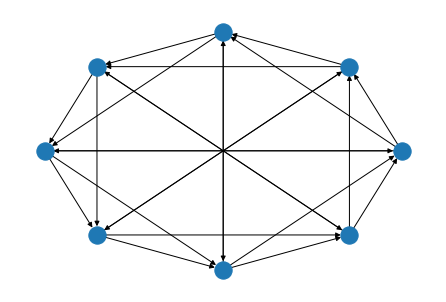

In [55]:
# plot figure
%px G = topology_util.ExponentialTwoGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

In [56]:
%%px

# set topology as exponetial-2 graph
bf.set_topology(G)
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(topology, bf.rank())

# scale weights
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)
        
self_weight = (self_weight+1)/2
for k, v in neighbor_weights.items():
    neighbor_weights[k] = v/2
    
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)

[stdout:1] 
self weights: 0.25

neighbor weights:
4 0.25
6 0.25
7 0.25
self weights: 0.625

neighbor weights:
4 0.125
6 0.125
7 0.125


In [60]:
# run EXTRA
maxite = 2000

for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
        
    %px y, yp, gp = EXTRA_one_recursion(y, gp, yp, ATA, A, b, x_sol, lr, self_weight, neighbor_weights)

Progress 0/2000
Progress 100/2000
Progress 200/2000
Progress 300/2000
Progress 400/2000
Progress 500/2000
Progress 600/2000
Progress 700/2000
Progress 800/2000
Progress 900/2000
Progress 1000/2000
Progress 1100/2000
Progress 1200/2000
Progress 1300/2000
Progress 1400/2000
Progress 1500/2000
Progress 1600/2000
Progress 1700/2000
Progress 1800/2000
Progress 1900/2000


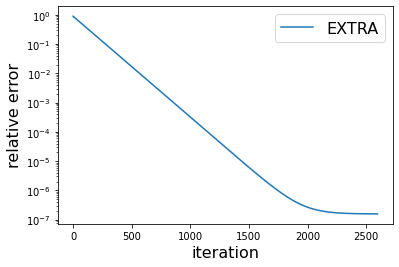

In [61]:
# pull averaged relative error list from node 0 
record_extra_0 = dview.pull('record_extra', block=True, targets=0)
%matplotlib inline
plt.semilogy(record_extra_0)
plt.xlabel('iteration', fontsize=16)
plt.ylabel('relative error',fontsize=16)
plt.legend(['EXTRA'],fontsize=16)

**Note**: 

- The relative error is around $10^{-7}$ because the KKT conditon of the centralized solution is with the precision level $10^{-7}$.

- In the $y$-axis, the averaged relative error is computed as $\sqrt{\frac{1}{n}\sum_{i=1}^n \|x_i^k - x_i^\star\|^2/\|x_i^\star\|^2}$

### 6.2 Exact Diffusion

To solve the dual consensus problem, EXTRA has the following recursions:

\begin{equation*}
\begin{split}
y_i^{k+1} & = \sum_{j=1}^n \bar{w}_{ij}\big( 2 y_j^k - y_j^{k-1} - \alpha (g_i(y_i^{k}) - g_i(y_i^{k-1})) \big), \quad k=1,2,\cdots  \\
x_i^{k+1} &= - g_i(y_i^{k+1})
\end{split}
\end{equation*}

where $g_j(y) = \nabla F_j(y)$, and we set the initialization $y_i^{1} = y_i^{0} = 0$, and let $g_i(y_i^{0}) = 0$. The weight $\bar{w}_{ij}$ is defined the same as that in EXTRA algorithm. It is observed that Exact Diffusion is almost the same as EXTRA, except that the combination matrix $\bar{w}_{ij}$ is also associated with the gradient.

In this subsection we will try a different way to set up topology and weights.

In [62]:
%%px

# set up topology and weights
G = topology_util.ExponentialGraph(bf.size())
W = nx.to_numpy_array(G)
W = (W + np.eye(bf.size()))/2
G = nx.from_numpy_matrix(W, create_using=nx.DiGraph)
bf.set_topology(G, is_weighted=True)

Out[0:5141]: True

Out[1:5141]: True

Out[2:5141]: True

Out[3:5141]: True

Out[4:5141]: True

Out[5:5141]: True

Out[6:5141]: True

Out[7:5141]: True

In [3]:
%%px

# Exact Diffusion
def Exact_diffusion_one_recursion(y, gp, yp, ATA, A, b, x_sol, lr):
    
    x = ATA.mm(A.T.mm(b) - y)
    g = -x
    
    # note that we don't need to explicitly specify options 'self_weight' and 'neighbor_weights' 
    # here because we have set G as topology and weights with the code:
    # bf.set_topology(G, is_weighted=True)
    # With the above code, we will use the weights specified by G in the following bf.neighbor_allreduce() function
    yn = bf.neighbor_allreduce(2*y - yp - lr*(g - gp), name='y')
    gp = g.clone()
    yp = y.clone()
    y  = yn.clone()
    
    dist = torch.norm(x - x_sol, p=2)/torch.norm(x_sol, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    record_exact_diffusion.append(torch.sqrt(averaged_relative_error))
    
    return y, yp, gp

In [68]:
%%px

# initialization
lr = 0.08
ATA = torch.inverse(A.T.mm(A))
y = torch.zeros(d, 1)
yp = torch.zeros(d, 1)
gp = torch.zeros(d, 1)
record_exact_diffusion = []

In [69]:
%%px

# set topology and generate weight w_bar = (w + 1)/2
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(
    topology, bf.rank())

if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)

[stdout:1] 
self weights: 0.625

neighbor weights:
4 0.125
6 0.125
7 0.125


In [72]:
# run Exact Diffusion
maxite = 2000

for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
        
    %px y, yp, gp = Exact_diffusion_one_recursion(y, gp, yp, ATA, A, b, x_sol, lr)

Progress 0/2000
Progress 100/2000
Progress 200/2000
Progress 300/2000
Progress 400/2000
Progress 500/2000
Progress 600/2000
Progress 700/2000
Progress 800/2000
Progress 900/2000
Progress 1000/2000
Progress 1100/2000
Progress 1200/2000
Progress 1300/2000
Progress 1400/2000
Progress 1500/2000
Progress 1600/2000
Progress 1700/2000
Progress 1800/2000
Progress 1900/2000


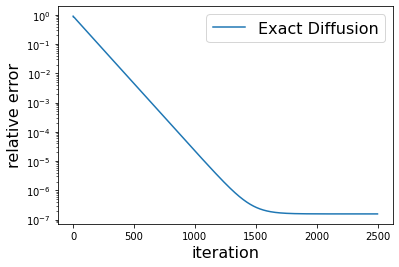

In [73]:
# pull averaged relative error list from node 0 
record_exact_diffusion_0 = dview.pull('record_exact_diffusion', block=True, targets=0)
%matplotlib inline
plt.semilogy(record_exact_diffusion_0)
plt.xlabel('iteration', fontsize=16)
plt.ylabel('relative error',fontsize=16)
plt.legend(['Exact Diffusion'],fontsize=16)

### 6.3 Gradient tracking

To solve the dual consensus problem, gradient tracking has the following recursions:

\begin{equation*}
\begin{split}
y_i^{k+1} &= \sum_{j=1}^n w_{ij}(y_j^k + \alpha z_j^k) \\
z_i^{k+1} &= \sum_{j=1}^n w_{ij}\big(z_j^k + g_j(y_j^{k+1}) - g_j(y_j^{k})\big) \\
x_i^{k+1} &= - g_i(y_i^{k+1})
\end{split}
\end{equation*}

where $g_j(y) = \nabla F_j(y)$ and $z_i^0 = g_i(y_i^0)$

In [74]:
%%px

# gradient tracking
def gradient_tracking_one_recursion(y, z, gp, ATA, A, b, x_sol, lr):
    
    y = bf.neighbor_allreduce(y - lr*z, name='y')
    x = ATA.mm(A.T.mm(b) - y)
    g = -x
    z = bf.neighbor_allreduce(z + g - gp, name='z')
    gp = g.clone()
    
    dist = torch.norm(x - x_sol, p=2)/torch.norm(x_sol, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    record_gt.append(torch.sqrt(averaged_relative_error))
    
    return y, z, gp

In [78]:
%%px

# initialization
lr = 0.1
ATA = torch.inverse(A.T.mm(A))
y = torch.zeros(d, 1)
gp = ATA.mm(A.T.mm(b) - y)
z = ATA.mm(A.T.mm(b) - y)
record_gt = []

In [81]:
# run gradient tracking
maxite = 1500

for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
        
    %px y, z, gp = gradient_tracking_one_recursion(y, z, gp, ATA, A, b, x_sol, lr)

Progress 0/1500
Progress 100/1500
Progress 200/1500
Progress 300/1500
Progress 400/1500
Progress 500/1500
Progress 600/1500
Progress 700/1500
Progress 800/1500
Progress 900/1500
Progress 1000/1500
Progress 1100/1500
Progress 1200/1500
Progress 1300/1500
Progress 1400/1500


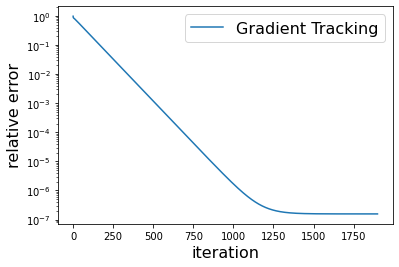

In [82]:
# pull averaged relative error list from node 0 
record_gt_0 = dview.pull('record_gt', block=True, targets=0)
%matplotlib inline
plt.semilogy(record_gt_0)
plt.xlabel('iteration', fontsize=16)
plt.ylabel('relative error',fontsize=16)
plt.legend(['Gradient Tracking'],fontsize=16)

## 7. References

\[1\] S. Boyd, N. Parikh, E. Chu, B. Peleato, and J. Eckstein, *Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers*, Foundations and Trends in Machine Learning, 3(1):1–122, 2011.

\[2\] W. Shi, Q. Ling, G. Wu, and W. Yin, *EXTRA: An Exact First-Order Algorithm for Decentralized Consensus Optimization*, SIAM Journal on Optimization 25, no. 2 (2015): 944-966.

\[3\] K. Yuan, B. Ying, X. Zhao, and A.H. Sayed, *Exact Diffusion for Distributed Optimization and Learning—Part I: Algorithm Development*, IEEE Transactions on Signal Processing, 67(3), pp.708-723.

\[4\] A. Nedic, A. Olshevsky, and W. Shi, *Achieving Geometric Convergence for Distributed Optimization over Time-varying graphs", SIAM Journal on Optimization 27.4 (2017): 2597-2633.